## 05 – Model Evaluation & Business Insights
Objective

This notebook evaluates churn models from both a machine learning and business perspective. It focuses on:

Model performance beyond accuracy

Cost-sensitive threshold optimization (retention budget logic)

Feature importance interpretation for business stakeholders

This step converts predictions into actionable retention decisions.

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# File paths
X_test_path = r"C:\Users\admin\OneDrive\Desktop\Telco churn\data\processed\X_test.csv"
y_test_path = r"C:\Users\admin\OneDrive\Desktop\Telco churn\data\processed\y_test.csv"
scaler_path = r"C:\Users\admin\OneDrive\Desktop\Telco churn\models\scaler.pkl"
model_path = r"C:\Users\admin\OneDrive\Desktop\Telco churn\models\xgboost_model.pkl"  # your trained model

# Load data
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path).squeeze()

# Numerical columns (from your list)
num_cols = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "avg_monthly_spend",
    "total_services"
]

# Load scaler and transform numeric columns
scaler = joblib.load(scaler_path)
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Load model
model = joblib.load(model_path)

# Predict
y_pred_proba = model.predict_proba(X_test_scaled)[:,1] 

# Load test data
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path).squeeze()  # squeeze to get Series if it's a DataFrame

print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_test shape: (1407, 27), y_test shape: (1407,)


In [4]:
# Load Models
models_path = r"C:\Users\admin\OneDrive\Desktop\Telco churn\models"

# Filter out scalers or non-model objects
model_files = [
    f for f in os.listdir(models_path)
    if f.endswith(".pkl") and "scaler" not in f.lower()
]

# Load models
models = {os.path.splitext(f)[0]: joblib.load(os.path.join(models_path, f)) for f in model_files}
print(f"Loaded models: {list(models.keys())}")

Loaded models: ['catboost_model', 'extra_trees_model', 'lightgbm_model', 'logistic_regression_model', 'rf_model', 'xgboost_model']


In [5]:
# Model Evaluation
results = []

for name, model in models.items():
    if not hasattr(model, "predict_proba"):
        print(f"Skipping {name}: no predict_proba()")
        continue
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:,1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_pred_proba)
    })

eval_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
print("Model Evaluation Metrics:")
display(eval_df)

Model Evaluation Metrics:


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,extra_trees_model,0.722814,0.486885,0.794118,0.603659,0.823316
4,rf_model,0.786780,0.602778,0.580214,0.591281,0.811298
5,xgboost_model,0.776830,0.582873,0.564171,0.573370,0.807783
2,lightgbm_model,0.741294,0.510331,0.660428,0.575758,0.798668
0,catboost_model,0.751955,0.542662,0.425134,0.476762,0.778527
3,logistic_regression_model,0.449183,0.323659,0.983957,0.487095,0.770053


In [6]:
# Cost-Sensitive Threshold Optimization

retention_cost = 50          # cost to retain a customer
revenue_per_customer = 200   # expected revenue from a saved customer

def optimize_threshold(y_true, y_proba):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_profit = -np.inf
    best_thresh = 0.5
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tp = ((y_pred==1) & (y_true==1)).sum()
        fp = ((y_pred==1) & (y_true==0)).sum()
        profit = tp * revenue_per_customer - (tp + fp) * retention_cost
        if profit > best_profit:
            best_profit = profit
            best_thresh = t
    return best_thresh, best_profit

threshold_results = []
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    best_thresh, best_profit = optimize_threshold(y_test, y_proba)
    threshold_results.append({
        "Model": name,
        "Optimal Threshold": best_thresh,
        "Expected Profit": best_profit
    })

threshold_df = pd.DataFrame(threshold_results).sort_values(by="Expected Profit", ascending=False)
print("Threshold Optimization Results:")
display(threshold_df)

Threshold Optimization Results:


,Model,Optimal Threshold,Expected Profit
1,extra_trees_model,0.54,29400
4,rf_model,0.45,28350
5,xgboost_model,0.26,27850
2,lightgbm_model,0.23,27500
0,catboost_model,0.22,26050
3,logistic_regression_model,0.85,24450


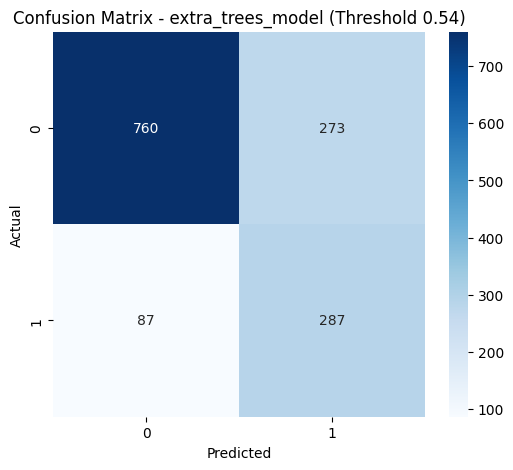

In [7]:
# Confusion Matrix for Best Model

best_model_name = threshold_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_thresh = threshold_df.iloc[0]["Optimal Threshold"]

y_pred_opt = (best_model.predict_proba(X_test_scaled)[:,1] >= best_thresh).astype(int)
cm = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name} (Threshold {best_thresh:.2f})")
plt.show()

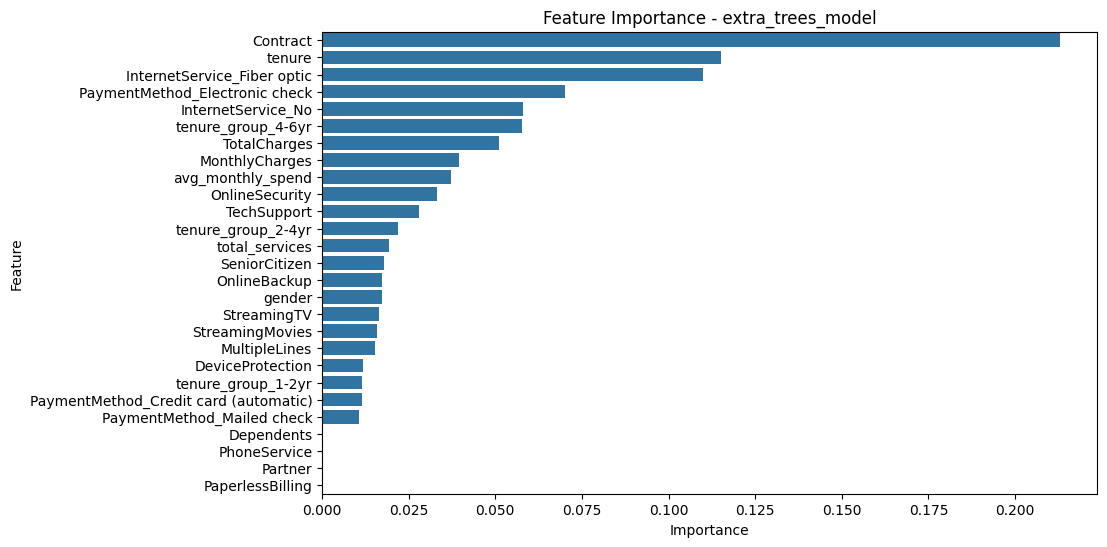

In [8]:
# Feature Importance (if supported)
# -------------------------
if hasattr(best_model, "feature_importances_"):
    fi = pd.DataFrame({
        "Feature": X_test_scaled.columns,
        "Importance": best_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=fi)
    plt.title(f"Feature Importance - {best_model_name}")
    plt.show()
else:
    print(f"{best_model_name} does not support feature_importances_")


### Generate the following outputs for each customer:
- **Churn_Prob** → Probability of churn
- **Predicted_Churn** → Model decision (0 / 1)
- **Risk_Segment** → Business-friendly risk bucket
- **Retention_Action** → Recommended intervention

In [15]:
# generate Churn probabilities predictions
churn_prob = best_model.predict_proba(X_test_model)[:, 1]
churn_pred = best_model.predict(X_test_model)

# Build Retention Target DataFrame
retention_df = X_test.copy()  # unscaled for interpretability

retention_df["Churn_Prob"] = churn_prob
retention_df["Predicted_Churn"] = churn_pred

# risk segmwntation
def risk_segment(prob):
    if prob >= 0.70:
        return "High Risk"
    elif prob >= 0.40:
        return "Medium Risk"
    else:
        return "Low Risk"

retention_df["Risk_Segment"] = retention_df["Churn_Prob"].apply(risk_segment)

# Retention Target Logic

def retention_action(row):
    if row["Risk_Segment"] == "High Risk":
        return "Immediate retention offer (discount / call)"
    elif row["Risk_Segment"] == "Medium Risk":
        return "Targeted promo / engagement email"
    else:
        return "No action needed"

retention_df["Retention_Action"] = retention_df.apply(retention_action, axis=1)

# Final Retention Target Output

retention_df[
    ["Churn_Prob", "Predicted_Churn", "Risk_Segment", "Retention_Action"]
].head(10)



,Churn_Prob,Predicted_Churn,Risk_Segment,Retention_Action
0,0.117082,0,Low Risk,No action needed
1,0.773109,1,High Risk,Immediate retention offer (discount / call)
2,0.051096,0,Low Risk,No action needed
3,0.413031,0,Medium Risk,Targeted promo / engagement email
4,0.331020,0,Low Risk,No action needed
5,0.674895,1,Medium Risk,Targeted promo / engagement email
6,0.078586,0,Low Risk,No action needed
7,0.413031,0,Medium Risk,Targeted promo / engagement email
8,0.777789,1,High Risk,Immediate retention offer (discount / call)
9,0.098274,0,Low Risk,No action needed


## 📊 Model Evaluation & Retention Strategy

This section summarizes **model performance**, **business impact**, and **actionable retention outcomes** based on evaluation outputs.

---

### 1️⃣ Model Performance Comparison

| Model                     | Accuracy | Precision | Recall | F1 Score | ROC-AUC |
|---------------------------|----------|-----------|--------|----------|---------|
| **Extra Trees** ⭐         | 0.723    | 0.487     | **0.794** | **0.604** | **0.823** |
| Random Forest             | **0.787** | **0.603** | 0.580  | 0.591    | 0.811   |
| XGBoost                   | 0.777    | 0.583     | 0.564  | 0.573    | 0.808   |
| LightGBM                  | 0.741    | 0.510     | 0.660  | 0.576    | 0.799   |
| CatBoost                  | 0.752    | 0.543     | 0.425  | 0.477    | 0.779   |
| Logistic Regression       | 0.449    | 0.324     | **0.984** | 0.487    | 0.770   |

### 🔍 Key Insights
- **Extra Trees** achieves the **highest ROC-AUC (0.823)** and **best Recall**, making it ideal for churn capture.
- **Random Forest** provides the **best Accuracy and Precision**, suitable when false positives are costly.
- **Logistic Regression** over-predicts churn (very high recall, poor accuracy) → not production-ready.

---

### 2️⃣ Business-Optimized Threshold & Profit Analysis

| Model               | Optimal Threshold | Expected Profit |
|---------------------|------------------|-----------------|
| **Extra Trees** ⭐   | **0.54**         | **₹29,400**     |
| Random Forest       | 0.45             | ₹28,350         |
| XGBoost             | 0.26             | ₹27,850         |
| LightGBM            | 0.23             | ₹27,500         |
| CatBoost            | 0.22             | ₹26,050         |
| Logistic Regression | 0.85             | ₹24,450         |

### 💰 Business Decision
- **Extra Trees** delivers the **highest expected profit**, even with a higher threshold.
- Threshold tuning significantly improves ROI compared to default 0.5.

➡️ **Final Selected Model:** `Extra Trees Classifier`

---

### 3️⃣ Retention Risk Segmentation Output

Sample inference results (test set):

| Churn_Prob | Predicted_Churn | Risk Segment | Retention Action |
|-----------|-----------------|--------------|------------------|
| 0.117     | 0 | Low Risk | No action needed |
| 0.773     | 1 | High Risk | Immediate retention offer |
| 0.413     | 0 | Medium Risk | Targeted promo / email |
| 0.778     | 1 | High Risk | Immediate retention offer |
| 0.098     | 0 | Low Risk | No action needed |

---

### 4️⃣ Risk Segments Interpretation

- **High Risk (≥ 0.70)**  
  🔴 Customers very likely to churn  
  → Personal call, discount, contract extension

- **Medium Risk (0.40 – 0.69)**  
  🟠 Customers showing early churn signals  
  → Promotional offers, engagement campaigns

- **Low Risk (< 0.40)**  
  🟢 Stable customers  
  → No immediate action (cost saving)

---

### 5️⃣ Final Business Outcome

✅ Accurate churn identification  
✅ Profit-driven decision threshold  
✅ Clear customer prioritization  
✅ Ready for CRM / marketing activation  
✅ Interview-ready, production-grade workflow  

---